In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load the data
def load_data(file):
    return pd.read_csv(file)

# compute summary statistics of data
def summarise_data(df):
    print(df.describe())

# call functions
df = load_data('London_Listings.csv')
summarise_data(df)
print(df.dtypes)

                 id       host_id  host_listings_count  \
count  6.667900e+04  6.667900e+04         66678.000000   
mean   6.129241e+17  2.058000e+08            28.557110   
std    4.728136e+17  1.975357e+08           152.576905   
min    1.391300e+04  2.594000e+03             1.000000   
25%    3.982489e+07  2.764800e+07             1.000000   
50%    8.040000e+17  1.274832e+08             2.000000   
75%    1.030000e+18  4.024643e+08            11.000000   
max    1.180000e+18  5.831673e+08          2566.000000   

       host_total_listings_count      latitude     longitude  accommodates  \
count               66678.000000  66679.000000  66679.000000  66679.000000   
mean                   53.579606     51.509255     -0.128281      3.417733   
std                   354.866876      0.049343      0.103179      2.106704   
min                     1.000000     51.295937     -0.497800      1.000000   
25%                     1.000000     51.484038     -0.190809      2.000000   
50%      

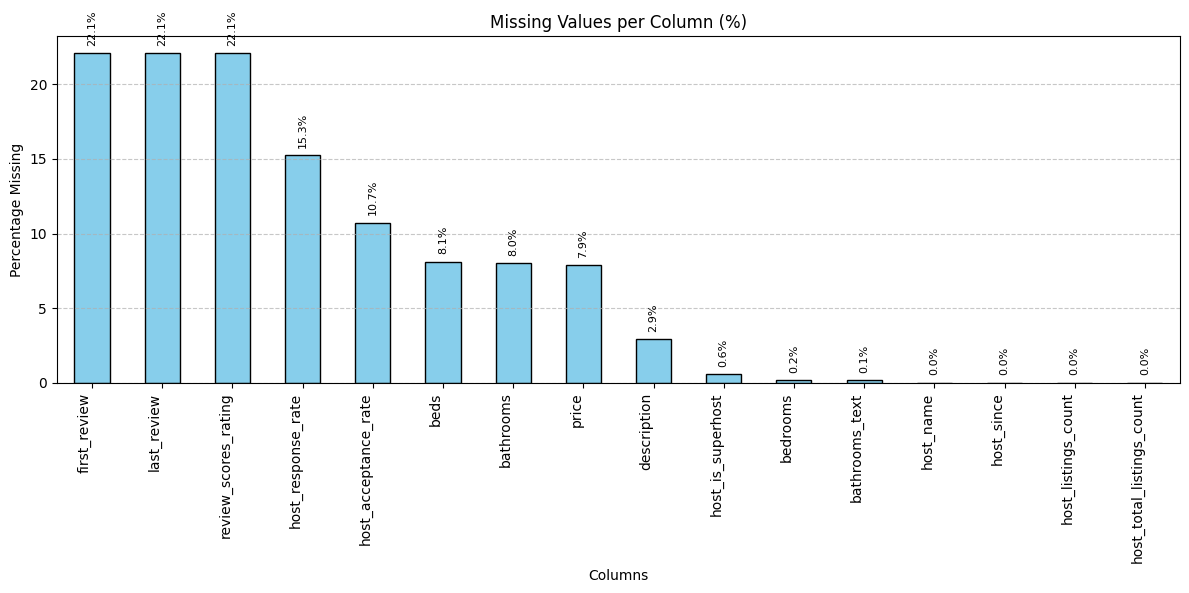

In [36]:
# visualise missing values
def visualize_missing_values(df, threshold=0.0):
    # find percentage of missing vals
    missing_percent = (df.isnull().sum() / len(df)) * 100

    # filter columns above threshold
    missing_percent = missing_percent[missing_percent > threshold]

    if missing_percent.empty:
        print("No missing values above threshold found in the dataset.")
        return

    # sort descending
    missing_percent = missing_percent.sort_values(ascending=False)

    # plot bar chart
    plt.figure(figsize=(12, 6))
    ax = missing_percent.plot(kind='bar', color='skyblue', edgecolor='black')

    # annotate bars with %
    for i, v in enumerate(missing_percent):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=8, rotation=90)

    plt.title('Missing Values per Column (%)')
    plt.xlabel('Columns')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

visualize_missing_values(df)

In [37]:
# inital basic data cleaning
def initial_clean(df):
    # replace N/A with np.nan
    df.replace("N/A", np.nan, inplace=True)
    
    # convert percentages
    df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float)
    
    # remove dollar sign and comma from price
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

    # convert to bool
    df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})

    # date parsing
    date_cols = ['host_since', 'calendar_last_scraped', 'first_review', 'last_review']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)


    return df

# dropping irrelvant cols & those with low predictive power
def remove_cols(df):
    cols_to_drop = [
        'id',
        'name',
        'description',
        'host_id',
        'host_name',
        'host_listings_count',
        'calculated_host_listings_count',
        'calendar_last_scraped'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    return df

df = remove_cols(initial_clean(df))
summarise_data(df)

                          host_since  host_response_rate  \
count                          66678        56504.000000   
mean   2017-12-16 19:37:42.755331584           92.797183   
min              2008-08-28 00:00:00            0.000000   
25%              2015-02-22 00:00:00           98.000000   
50%              2017-04-27 00:00:00          100.000000   
75%              2021-05-19 00:00:00          100.000000   
max              2024-06-12 00:00:00          100.000000   
std                              NaN           19.812710   

       host_acceptance_rate  host_is_superhost  host_total_listings_count  \
count          59533.000000       66299.000000               66678.000000   
mean              82.970269           0.237756                  53.579606   
min                0.000000           0.000000                   1.000000   
25%               77.000000           0.000000                   1.000000   
50%               97.000000           0.000000                   4.000000 

In [38]:
# handle missing values - prevent skewing
def handle_missing(df):
    df = df.copy()
    # remove rows with missing price
    df = df[~df['price'].isnull()]

    # replace review_scores_rating with NaN if there are no reviews
    df['has_reviews'] = (df['number_of_reviews'] > 0).astype(int)
    df.loc[df['number_of_reviews'] == 0, 'review_scores_rating'] = np.nan

    # fill with grouped median of similar properties
    df['review_scores_rating'] = df['review_scores_rating'].fillna(
        df.groupby(['neighbourhood', 'room_type', 'accommodates'])['review_scores_rating'].transform('median')
    )

    # time since last reviews
    today = pd.Timestamp('today')
    df['days_since_first_review'] = (today - df['first_review']).dt.days.fillna(0)
    df['days_since_last_review'] = (today - df['last_review']).dt.days.fillna(0)
    df.drop(columns=['first_review', 'last_review'], inplace=True)

    # flag missing response rates and fill with median
    df['response_rate_missing'] = df['host_response_rate'].isnull().astype(int)
    df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())

    # flag missing acceptance rates and fill with median
    df['acceptance_rate_missing'] = df['host_acceptance_rate'].isnull().astype(int)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median())

    # fill with median for similar properties
    df['beds'] = df.groupby(['accommodates', 'room_type'])['beds'].transform(
        lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(x.median())
    )
    df['bedrooms'] = df.groupby(['accommodates', 'room_type'])['bedrooms'].transform(
        lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(x.median())
    )

    # fill with medians
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
    df['host_is_superhost'] = df['host_is_superhost'].fillna(df['host_is_superhost'].mode()[0])
    df['host_total_listings_count'] =  df['host_total_listings_count'].fillna(df['host_total_listings_count'].median())
    
    # fill with median
    median_date = df['host_since'].dropna().median()
    df['host_since'] = df['host_since'].fillna(median_date)
    
    return df

df = handle_missing(df)


In [39]:
# log transform listings count
def transform_features(df):
    df['log_price'] = np.log1p(df['price'])
    df['log_host_listings'] = np.log1p(df['host_total_listings_count'])
    df['log_accommodates'] = np.log1p(df['accommodates'])
    df['log_beds'] = np.log1p(df['beds'])
    df['log_days_since_last_review'] = np.log1p(df['days_since_last_review'])
    return df

# winsorise outliers
def handle_outliers(df, columns, lower_q=0.01, upper_q=0.99):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            lower = df[col].quantile(lower_q)
            upper = df[col].quantile(upper_q)
            df[col] = df[col].clip(lower, upper)
    return df

df = handle_outliers(df, ['price', 'beds', 'accommodates', 'bedrooms'])
df = transform_features(df)

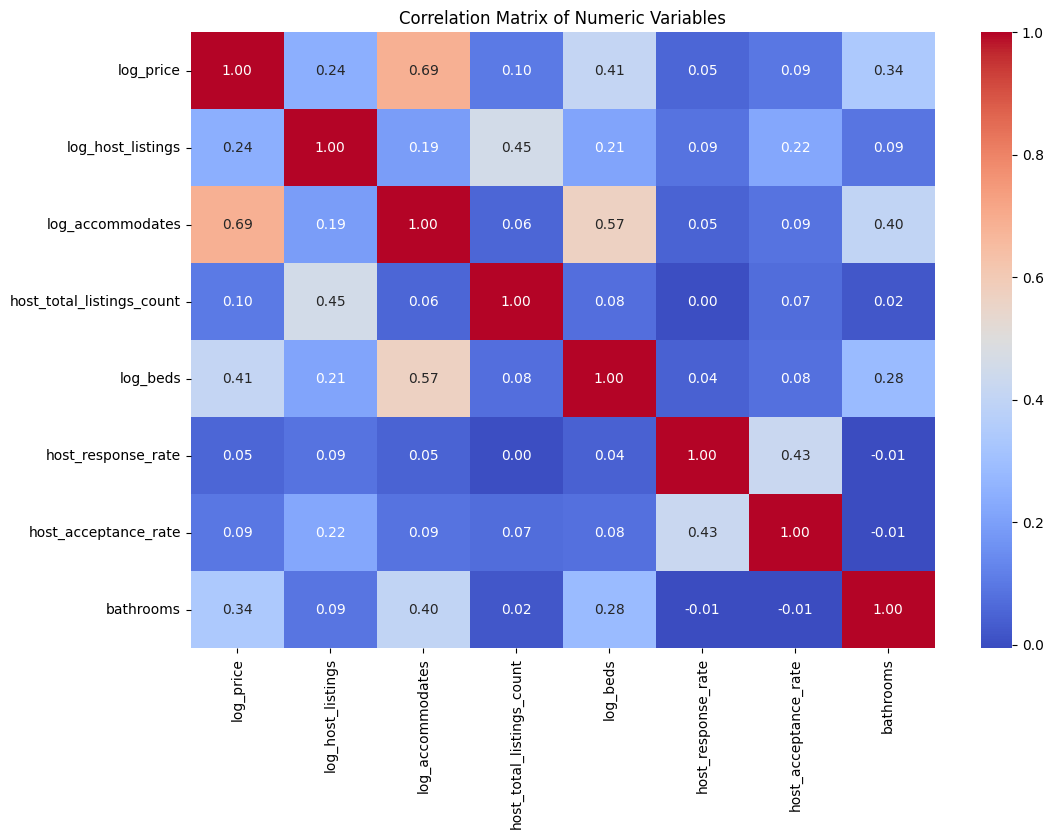

In [40]:
# visualise heatmap between all variable pairs
def plot_correlation_heatmap(df, vars):
    if df is None:
        return

    # use corr matrix to get corr numbers
    if len(vars) > 1:
        corr_matrix = df[vars].corr()

        # plot heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title("Correlation Matrix of Numeric Variables")
        plt.show()
    else:
        print("Not enough numerical variables for correlation heatmap.")

plot_correlation_heatmap(df, ['log_price', "log_host_listings", "log_accommodates",'host_total_listings_count',
                              "log_beds",'host_response_rate','host_acceptance_rate','bathrooms'])


/var/folders/41/b93h2wqj4zv874gqdl0b859r0000gn/T/ipykernel_2364/714923405.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='neighbourhood', y='log_price',


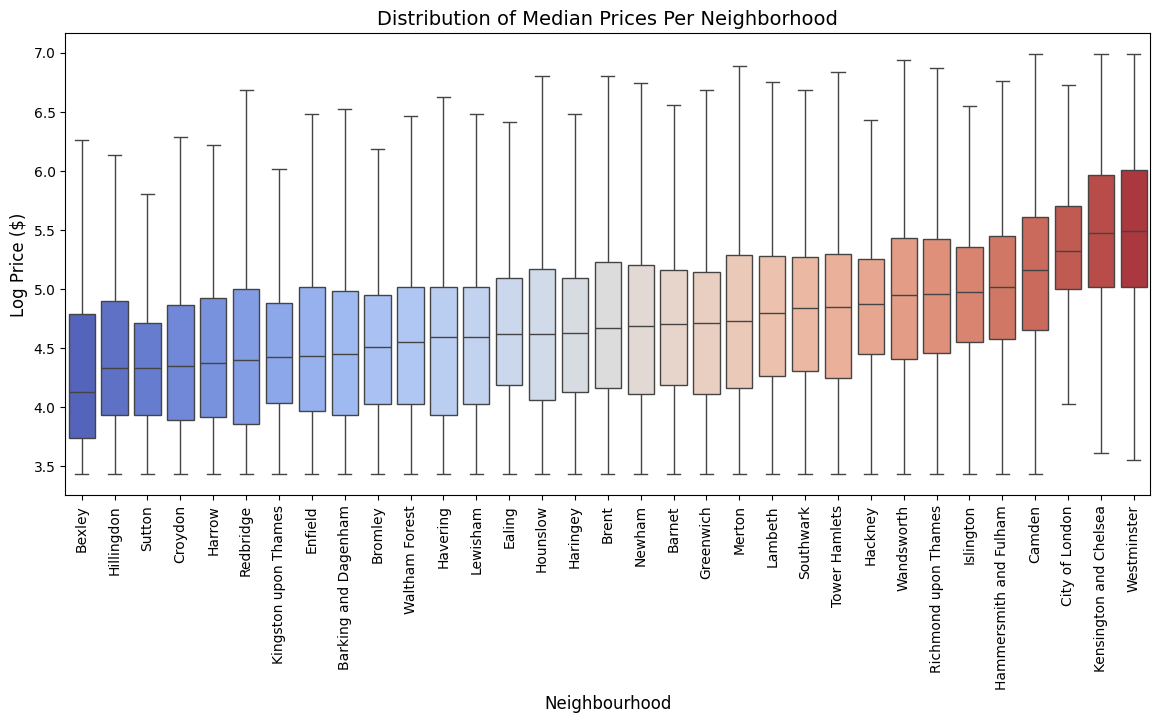

In [41]:
# visualise how prices change with neighbourhood
def plot_neighbourhood_prices(df):
    if df is None or 'neighbourhood' not in df.columns or 'log_price' not in df.columns:
        print("Error: 'neighbourhood' or 'price' column is missing from the dataset.")
        return

    # filter neighbourhoods with < 10 points - need sufficient points
    neighbourhood_counts = df['neighbourhood'].value_counts()
    valid_neighbourhoods = neighbourhood_counts[neighbourhood_counts >= 10].index
    filtered_data = df[df['neighbourhood'].isin(valid_neighbourhoods)]

    # find median
    sorted_neighbourhoods = filtered_data.groupby('neighbourhood')['log_price'].median().sort_values().index

    # plot boxplot - shows average & outliers
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=filtered_data, x='neighbourhood', y='log_price',
                order=sorted_neighbourhoods, showfliers=False, palette="coolwarm")
    plt.xticks(rotation=90, fontsize=10)
    plt.xlabel("Neighbourhood", fontsize=12)
    plt.ylabel("Log Price ($)", fontsize=12)
    plt.title("Distribution of Median Prices Per Neighborhood", fontsize=14)
    plt.show()

plot_neighbourhood_prices(df)

/var/folders/41/b93h2wqj4zv874gqdl0b859r0000gn/T/ipykernel_2364/4173113251.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='room_type', y='log_price',


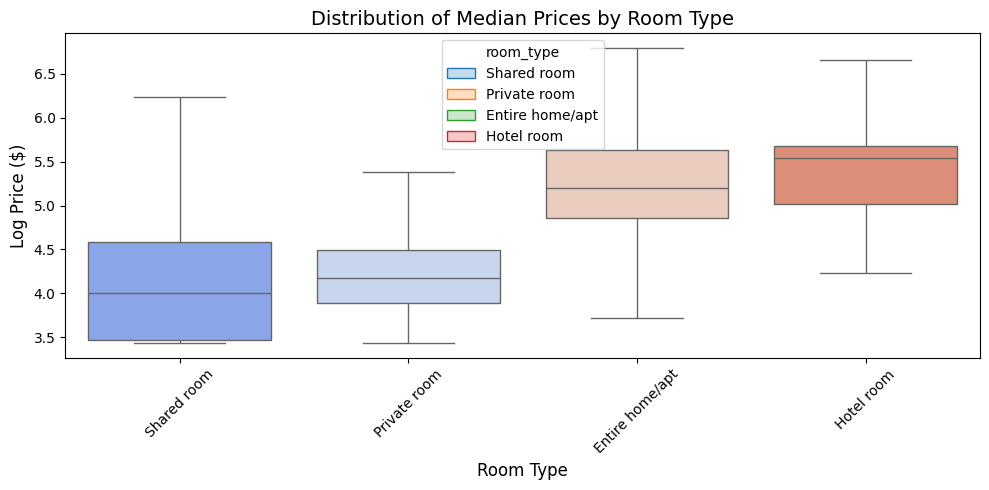

In [ ]:
# visualise how prices change with room type
def plot_room_type_prices(df):
    if df is None or 'room_type' not in df.columns or 'log_price' not in df.columns:
        print("Error: 'room_type' or 'log_price' column is missing from the dataset.")
        return

    # filter room types with at least 10 listings
    room_type_counts = df['room_type'].value_counts()
    valid_room_types = room_type_counts[room_type_counts >= 10].index
    filtered_data = df[df['room_type'].isin(valid_room_types)]

    # sort room types by median log_price
    sorted_room_types = filtered_data.groupby('room_type')['log_price'].median().sort_values().index

    # plot boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=filtered_data, x='room_type', y='log_price',
                order=sorted_room_types, showfliers=False, palette="coolwarm")
    plt.xticks(rotation=45, fontsize=10)
    plt.xlabel("Room Type", fontsize=12)
    plt.ylabel("Log Price ($)", fontsize=12)
    plt.title("Distribution of Median Prices by Room Type", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_room_type_prices(df)


/var/folders/41/b93h2wqj4zv874gqdl0b859r0000gn/T/ipykernel_2364/3638780127.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x='accommodates', y='log_price',


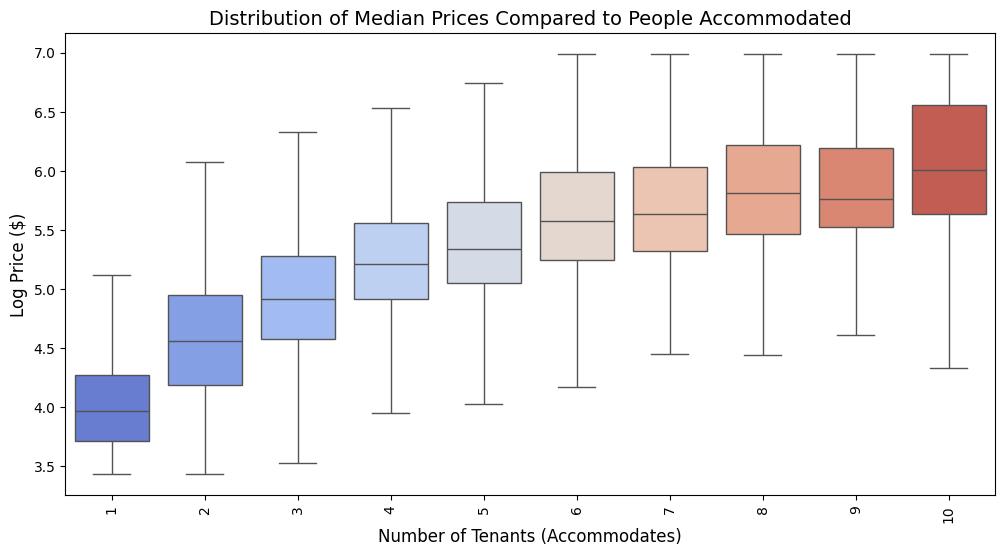

In [43]:
# visualise how prices change with number of tenants
def plot_accommodates_prices(df):
    if df is None or 'accommodates' not in df.columns or 'log_price' not in df.columns:
        print("Error: 'accommodates' or 'price' column is missing from the dataset.")
        return

    # filter neighbourhoods with < 10 points - need sufficient points
    accommodates_counts = df['accommodates'].value_counts()
    valid_accommodates = accommodates_counts[accommodates_counts >= 10].index
    filtered_data = df[df['accommodates'].isin(valid_accommodates)]

    # find median
    sorted_accommodates = sorted(valid_accommodates)

    # plot boxplot - shows average & outliers
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=filtered_data, x='accommodates', y='log_price',
                order=sorted_accommodates, showfliers=False, palette="coolwarm")
    plt.xticks(rotation=90, fontsize=10)
    plt.xlabel("Number of Tenants (Accommodates)", fontsize=12)
    plt.ylabel("Log Price ($)", fontsize=12)
    plt.title("Distribution of Median Prices Compared to People Accommodated", fontsize=14)
    plt.show()


plot_accommodates_prices(df)